# Project: Masters thesis - structuring optimal portfolio based on selected asset classes
**Abstract:** Creating multiple asset allocation strategies based on:  
1. manually selected securities 
2. bond & multi-asset ETFs 
3. Single multi-asset ETF's portfolios 
4. SP500
And then determining best strategies based on total returs and time of entry/exit.
**Data:** Stocks & Securities data  
**Source:** https://stooq.com/


## 1. Setting-up project environment

### 1.1 Importing packages & data

In [1]:
from urllib.request import urlretrieve
from datetime import datetime
from scipy import stats
import pandas as pd
import mplfinance as mpl #https://pypi.org/project/mplfinance/
import os
import string
import re
import numpy as np
import matplotlib.pyplot as plt


#Python portfolio optimizer
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

from IPython.display import display, HTML
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100



Useful:  
* dir() #list of variables  
* %whos #list of objects in environment  

### Research and links:  

* Markdown : https://www.markdownguide.org/basic-syntax/
* Sortino ratio: https://www.investopedia.com/terms/s/sortinoratio.asp
* Sharpe ratio: http://web.stanford.edu/~wfsharpe/art/sr/sr.htm

Libraries to explore:  
* https://www.activestate.com/blog/top-10-python-packages-for-finance-and-financial-modeling/
* https://quantlib-python-docs.readthedocs.io/en/latest/
* https://github.com/quandl/quandl-python
* https://github.com/quantopian/pyfolio
* https://gbeced.github.io/pyalgotrade/docs/v0.20/html/tutorial.html

Stooq data:
* https://www.quantstart.com/articles/an-introduction-to-stooq-pricing-data/

Portfolio analysis:
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-analysis-in-python 
* https://app.datacamp.com/learn/courses/quantitative-risk-management-in-python
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-risk-management-in-python
* https://app.datacamp.com/learn/courses/bond-valuation-and-analysis-in-python


### 1.2 Establishing portfolio parameters

In [2]:
# PARAMETERS for calculations
portfolio_stocks = ['AAPLUS','MSFTUS','AMZNUS','NVDAUS'] # securities chosen  for your porfolio "SPX","V80ADE","WIG","PKO"
portfolio_weights = np.array([0.25, 0.25, 0.25 ,0.25]) # weights for your securities in portfolio. Number of weights must match number of securities
capital = 100000 #starting capital
rfr = 0.0 # risk-free-rate
target_return = 0.0 # target return for Sortino ratio

In [3]:
ticker_list = ['WIG','WIG20','^SPX','V80A.DE','^TBSP','EURPLN','USDPLN','BTC.V','XAGPLN','XAUPLN','HUG','KGH','PCF','PKO','PZU',
              'AAPL.US', 'MSFT.US', 'AMZN.US', 'GOOGL.US', 'GOOG.US', 'TSLA.US', 'NVDA.US', 'META.US', 'BRK-B.US', 'UNH.US']

# WIG - index WIG
# WIG20 - top 20 companies of WIG index
# ^SPX - S&P500 index
# V80A.DE - Multi-Aasset ETF Vanguard Life Strategy 80/20 ACC EUR denominated (Xetra exchange; IKE DM BOS)
# ^TBSP - Polish treasury bonds index
# EURPLN - eur/pln exchange rate
# USDPLN - usd/pln exchange rate
# BTC.V - bitcoin price
# XAGPLN - silver (ozt - trojan ounce - 31,1034768 g)
# XAUPLN - gold (ozt - trojan ounce - 31,1034768 g)
# HUG - Huuuge Inc (game developer; MBank portfolio)
# KGH - KGHM (raw materials extractor - copper / silver ; MBank portfolio)
# PCF - PFC Group (game developer; MBank portfolio)
# PKO - PKO BP (polish bank (state owned); MBank portfolio)
# PZU - PZU (polish insurer (state owned); MBank portfolio)

#Stooq notes:  
#Indices are prefixed by ^ e.g. ^DJI (Dow Jones Industrial), ^UK100 (FTSE100)  
#US stocks are suffixed by .US e.g. AAPL.US, MSFT.US, TSLA.US  
#Cryptocurrencies are suffixed by .V e.g. BTC.V (BitCoin)  
#UK stocks are suffixed by .UK e.g. AV.UK (Aviva)  
#Price/Earnings are suffixed by _PE.US e.g. AAPL_PE.US  


### 1.3 Downloading portfolio data from stooq.com

In [4]:
#Creating data folder
data_folder="data/"

os.makedirs(data_folder, exist_ok=True)

In [5]:
#Downloading data for each security
for ticker in ticker_list:
    interval = 'd'
    url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
    csv_file = data_folder + ticker + '.csv'
    urlretrieve(url, csv_file)

In [6]:
# Inspect downloaded files
path, dirs, files = next(os.walk("./data"))
print(path)
print(dirs)
print(files)

./data
[]
['AAPL.US.csv', 'AMZN.US.csv', 'BRK-B.US.csv', 'BTC.V.csv', 'EURPLN.csv', 'GOOG.US.csv', 'GOOGL.US.csv', 'HUG.csv', 'KGH.csv', 'META.US.csv', 'MSFT.US.csv', 'NVDA.US.csv', 'PCF.csv', 'PKO.csv', 'PZU.csv', 'TSLA.US.csv', 'UNH.US.csv', 'USDPLN.csv', 'V80A.DE.csv', 'WIG.csv', 'WIG20.csv', 'XAGPLN.csv', 'XAUPLN.csv', '^SPX.csv', '^TBSP.csv']


### 1.4 Creating portfolio data dictionary

In [7]:
# Creating list of dataframe names out of tickers list 
# Deleting special characters
files_clean = []
pattern = r'[' + string.punctuation + ']'
for file in ticker_list:
    sample_str = re.sub(pattern, '', file)
    files_clean.append(sample_str)
    
# Sorting to match files order
files_clean.sort()

# Adjusting order of list to match files order - manual
element = 'SPX'
del files_clean[files_clean.index(element)]
files_clean.append(element)
element = 'TBSP'
del files_clean[files_clean.index(element)]
files_clean.append(element)

#displaying list
files_clean


['AAPLUS',
 'AMZNUS',
 'BRKBUS',
 'BTCV',
 'EURPLN',
 'GOOGLUS',
 'GOOGUS',
 'HUG',
 'KGH',
 'METAUS',
 'MSFTUS',
 'NVDAUS',
 'PCF',
 'PKO',
 'PZU',
 'TSLAUS',
 'UNHUS',
 'USDPLN',
 'V80ADE',
 'WIG',
 'WIG20',
 'XAGPLN',
 'XAUPLN',
 'SPX',
 'TBSP']

In [8]:
# Create a dictionary containing security name and corresponding dataframe
securities = dict()
for i, row in enumerate(files):
    print(row)
    dfName = files_clean[i]
    dfNew = pd.read_csv("./data/"+row, index_col='Date', parse_dates=['Date'],
                date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
    securities[dfName] = dfNew

#Check key names
securities.keys()

AAPL.US.csv
AMZN.US.csv
BRK-B.US.csv
BTC.V.csv
EURPLN.csv
GOOG.US.csv
GOOGL.US.csv
HUG.csv
KGH.csv
META.US.csv
MSFT.US.csv
NVDA.US.csv
PCF.csv
PKO.csv
PZU.csv
TSLA.US.csv
UNH.US.csv
USDPLN.csv
V80A.DE.csv
WIG.csv
WIG20.csv
XAGPLN.csv
XAUPLN.csv
^SPX.csv
^TBSP.csv


dict_keys(['AAPLUS', 'AMZNUS', 'BRKBUS', 'BTCV', 'EURPLN', 'GOOGLUS', 'GOOGUS', 'HUG', 'KGH', 'METAUS', 'MSFTUS', 'NVDAUS', 'PCF', 'PKO', 'PZU', 'TSLAUS', 'UNHUS', 'USDPLN', 'V80ADE', 'WIG', 'WIG20', 'XAGPLN', 'XAUPLN', 'SPX', 'TBSP'])

In [9]:
# Data dictionary check
# Adding daily return and cumulative return to chosen security
securities["SPX"]["daily_return"]=securities["SPX"]["Close"].pct_change()
securities["SPX"]["cum_return"]=(securities["SPX"]["daily_return"]+1).cumprod()
securities["SPX"]

,Open,High,Low,Close,Volume,daily_return,cum_return
Date,,,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN,NaN,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN,0.000000,1.000000
1789-07-01,0.50,0.50,0.50,0.50,NaN,-0.019608,0.980392
1789-08-01,0.50,0.51,0.50,0.51,NaN,0.020000,1.000000
1789-09-01,0.51,0.51,0.50,0.51,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...
2022-12-23,3815.11,3845.80,3797.01,3844.82,1.579203e+09,0.005868,7538.862745
2022-12-27,3843.34,3846.65,3813.22,3829.25,1.753562e+09,-0.004050,7508.333333
2022-12-28,3829.56,3848.32,3780.78,3783.22,1.741219e+09,-0.012021,7418.078431


## 2. Exploaratory Data Analysis (EDA)

### 2.1 Preliminary graph analysis

AAPLUS


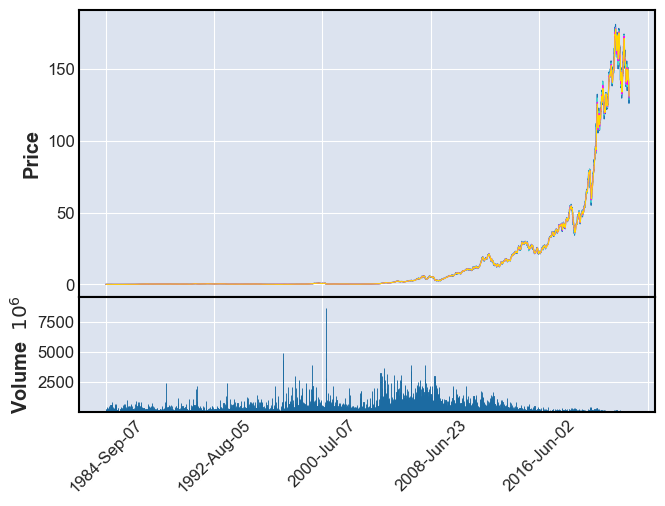

MSFTUS


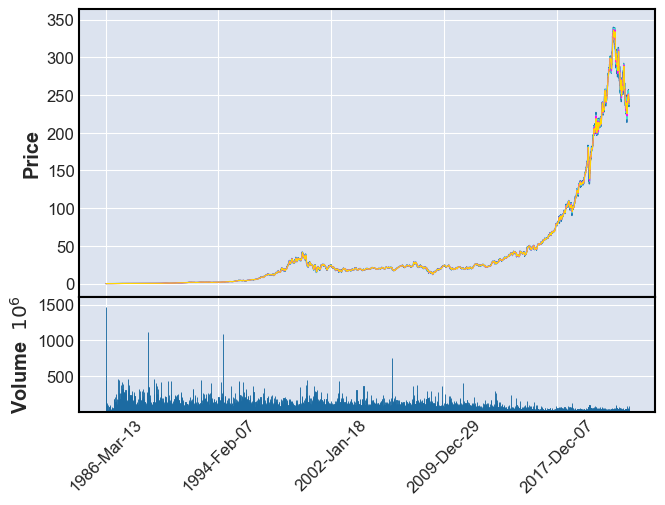

AMZNUS


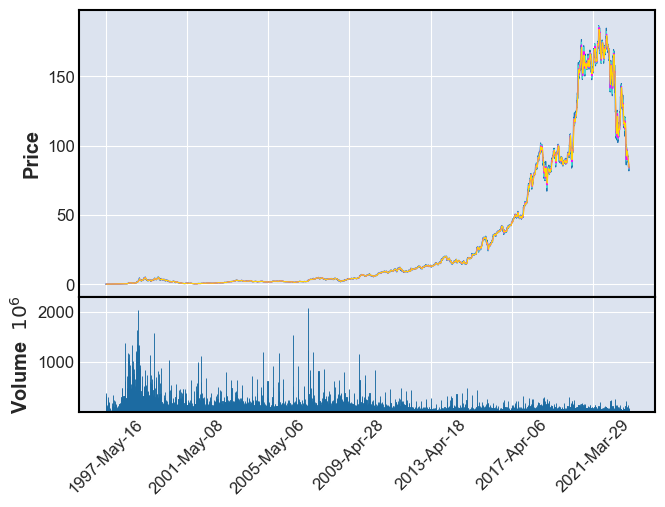

NVDAUS


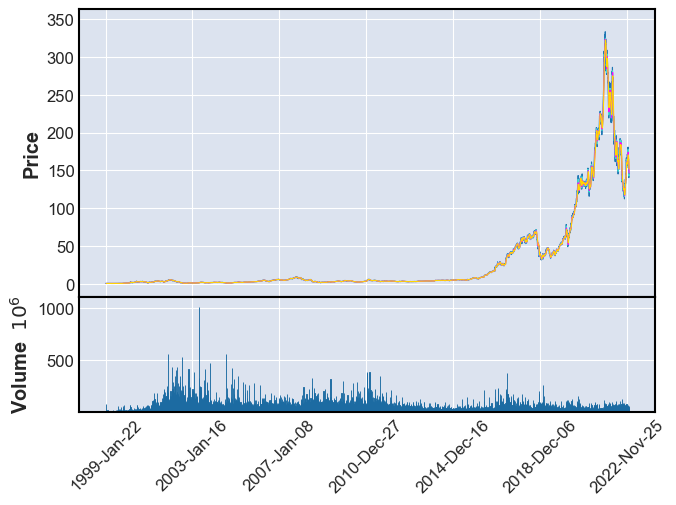

In [10]:
# Line graphs for chosen securities in portfollio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security], type='line', volume=True, mav=(3,6,9))

AAPLUS


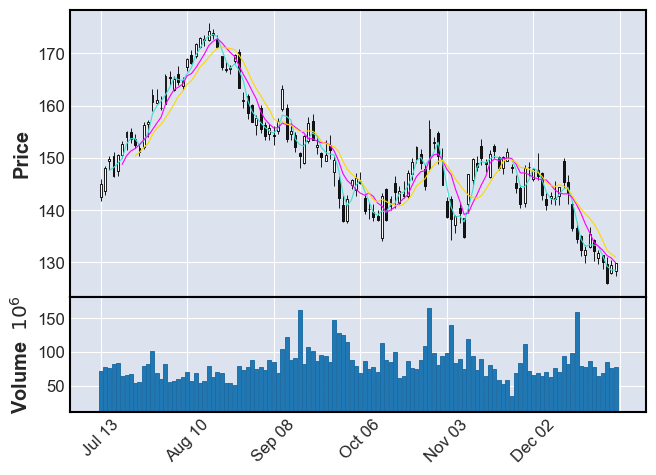

MSFTUS


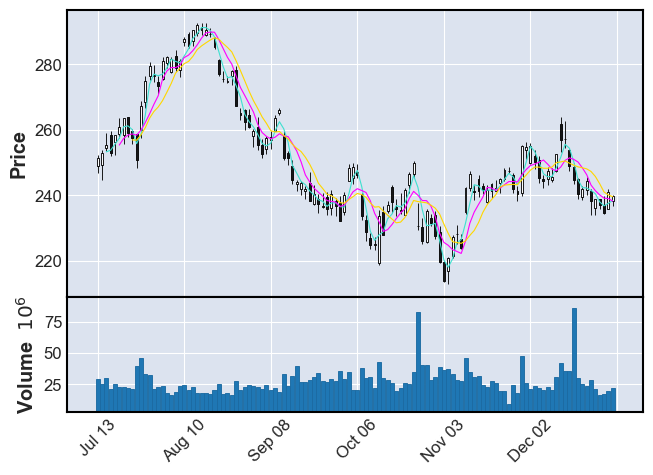

AMZNUS


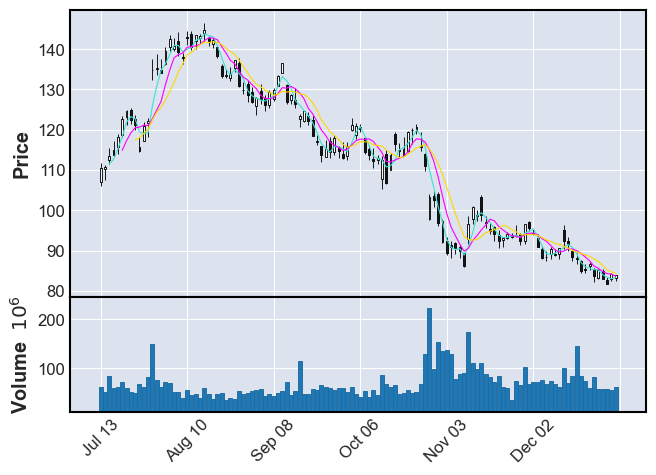

NVDAUS


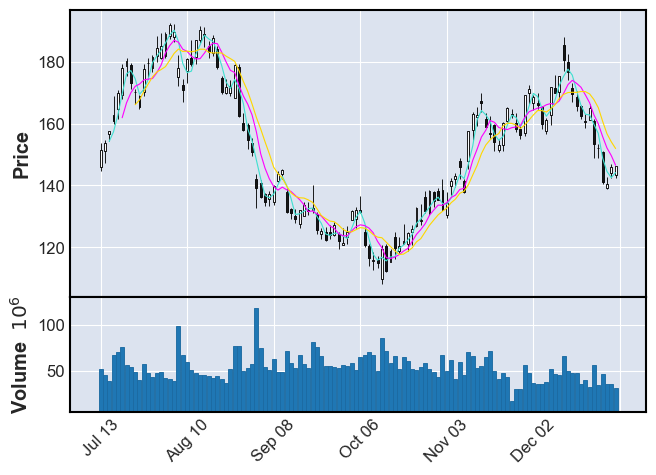

In [11]:
# Candle graphs for chosen securities in portfolio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security].tail(120), type='candle', volume=True, mav=(3,6,9))

### 2.2 Calculating portfolio statistics

In [12]:
#Creating portfolio

stocks = pd.DataFrame()
for item in portfolio_stocks:
    item = pd.Series(data=securities[item]["Close"], name=item)
    stocks = pd.merge(stocks, item, how='outer', left_index=True, right_index=True)
    

#Leaving only non-missing values for all observations (TBU : should we update missing values with last closing price?)
stocks = stocks[~stocks.isnull().any(axis=1)]

In [13]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2022-12-23,131.860000,238.7300,85.2500,152.060000
2022-12-27,130.030000,236.9600,83.0400,141.210000
2022-12-28,126.040000,234.5300,81.8200,140.360000


In [14]:
# Calculate daily returns from prices
stocks_dailyReturns = stocks.pct_change()

stocks_meanDailyReturns = stocks_dailyReturns.mean()
portfolio_return = np.sum(stocks_meanDailyReturns*portfolio_weights)
print('Average historic daily portfolio return: ', str(np.round(portfolio_return, 4) * 100) + '%')

Average historic daily portfolio return:  0.12%


In [15]:
#Calculate daily portfolio returns
portfolio_dailyReturns = pd.DataFrame()
portfolio_dailyReturns["Portfolio"]= stocks_dailyReturns.dot(portfolio_weights)
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2022-12-23,0.002056
2022-12-27,-0.029642
2022-12-28,-0.015413


In [16]:
# Compound the percentage returns over time 
stocks_dailyCumRet=(1+stocks_dailyReturns).cumprod()
display(HTML(stocks_dailyCumRet.tail().to_html()))

portfolio_dailyCumRet=(1+portfolio_dailyReturns).cumprod()
display(portfolio_dailyCumRet.tail())

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
2022-12-23,447.072465,8.667444,27.723577,404.101070
2022-12-27,440.867835,8.603181,27.004878,375.267080
2022-12-28,427.339705,8.514956,26.608130,373.008196
2022-12-29,439.443821,8.750222,27.375610,388.076281
2022-12-30,440.528784,8.707018,27.317073,388.368607


,Portfolio
Date,
2022-12-23,297.969845
2022-12-27,289.137292
2022-12-28,284.680874
2022-12-29,293.590958
2022-12-30,293.308112


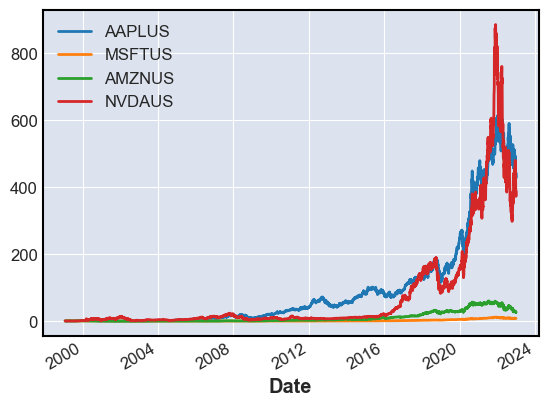

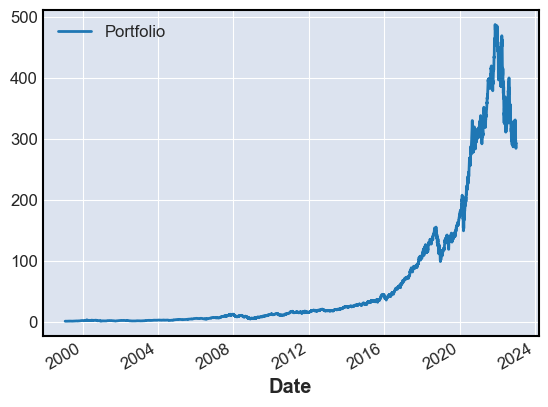

In [17]:
# Plot your cumulative return 
stocks_dailyCumRet.plot()
plt.show()
portfolio_dailyCumRet.plot()
plt.show()

In [18]:
#  The multiplication with 250 is to account for 250 trading days in a year.
stocks_covMatrix = stocks_dailyReturns.cov() * 250
display(stocks_covMatrix)
# Calculate the variance with the formula
portfolio_variance = np.dot(portfolio_weights.T, np.dot(stocks_covMatrix, portfolio_weights))


# Just converting the variance float into a percentage
print('Portfolio daily returns variance: ', str(np.round(portfolio_variance, 4) * 100) + '%')
print('Portfolio daily returns standard deviation: ', str(np.round(np.sqrt(portfolio_variance),4) * 100) + '%')

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.165491,0.059475,0.078431,0.100548
MSFTUS,0.059475,0.096222,0.070034,0.086448
AMZNUS,0.078431,0.070034,0.282059,0.105804
NVDAUS,0.100548,0.086448,0.105804,0.367338


Portfolio daily returns variance:  11.95%
Portfolio daily returns standard deviation:  34.57%


Good job! The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. The mean historic return of this particular portfolio is actually close to zero. With an average standard deviation of roughly 16%, this means you're getting a bad deal here! Now that you've learned how to calculate basic risk and return of a portfolio, you're ready to dive deeper into the world of portfolio analysis in the next chapters.

In [19]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2022-12-23,131.860000,238.7300,85.2500,152.060000
2022-12-27,130.030000,236.9600,83.0400,141.210000
2022-12-28,126.040000,234.5300,81.8200,140.360000


In [20]:
# doesn't account for weights in portfolio yet
years=(stocks.index[-1]-stocks.index[0])/ np.timedelta64(1, 'Y')

stocks_totalReturns = pd.DataFrame()

def total_return(data):
    return ((data[-1]-data[0])/data[0])
    
stocks_totalReturns["total_return"] = stocks.apply(total_return)
stocks_totalReturns["annualized_return"] = (((1+stocks_totalReturns["total_return"])**(1/years))-1)
print(stocks.index[0],' - portfolio start date')
print(stocks.index[-1],' - portfolio end date')
print(years,'years')
display(stocks_totalReturns)

1999-01-22 00:00:00  - portfolio start date
2022-12-30 00:00:00  - portfolio end date
23.93752096210052 years


,total_return,annualized_return
AAPLUS,439.528784,0.289594
MSFTUS,7.707018,0.094620
AMZNUS,26.317073,0.148174
NVDAUS,387.368607,0.282823


In [21]:
years

23.93752096210052

In [22]:
# Calculate annualized volatility from the standard deviation
# 250 accounts for 250 trading days in a year
stocks_volatility = stocks_dailyReturns.std() * np.sqrt(250)
display(stocks_volatility)

AAPLUS    0.406806
MSFTUS    0.310197
AMZNUS    0.531092
NVDAUS    0.606084
dtype: float64

In [23]:
# Calculate the Sharpe ratio 
stocks_sharpeRatio = ((stocks_totalReturns["annualized_return"] - rfr) / stocks_volatility)
display(stocks_sharpeRatio)

AAPLUS    0.711874
MSFTUS    0.305033
AMZNUS    0.278998
NVDAUS    0.466640
dtype: float64

In [24]:
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2022-12-23,0.002056
2022-12-27,-0.029642
2022-12-28,-0.015413


In [25]:
# ZASTANOW SIE CZY TO JEST OK
portfolio = pd.DataFrame()
portfolio["Portfolio"] = pd.DataFrame(data=np.dot(stocks, portfolio_weights))
portfolio.index=stocks.index
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2022-12-23,151.975000
2022-12-27,147.810000
2022-12-28,145.687500


In [26]:
# Portfolio statistics
portfolio_totalReturns = pd.DataFrame()
portfolio_totalReturns["total_return"] = portfolio.apply(total_return)
portfolio_totalReturns["annualized_return"] = (((1+portfolio_totalReturns["total_return"])**(1/years))-1)
display(portfolio_totalReturns)

,total_return,annualized_return
Portfolio,18.172226,0.131317


In [27]:
print(portfolio_dailyReturns.mean())

Portfolio    0.001183
dtype: float64


In [28]:
portfolio_variance = portfolio_dailyReturns.std()
display(portfolio_variance)

Portfolio    0.021867
dtype: float64

In [29]:
portfolio_volatility = portfolio_dailyReturns.std() * np.sqrt(250)
display(portfolio_volatility)

Portfolio    0.345741
dtype: float64

In [30]:
portfolio_sharpeRatio = ((portfolio_totalReturns["annualized_return"] - rfr) / portfolio_volatility)
display(portfolio_sharpeRatio)

Portfolio    0.379812
dtype: float64

In [31]:
stocks_totalReturns["mean_dailyReturn"]=stocks_dailyReturns.mean()*100
stocks_totalReturns["std_dailyReturn"]=stocks_dailyReturns.std()*100
stocks_totalReturns["skew_dailyReturn"]=stocks_dailyReturns.skew()
stocks_totalReturns["kurtosis_dailyReturn"]=stocks_dailyReturns.kurtosis()

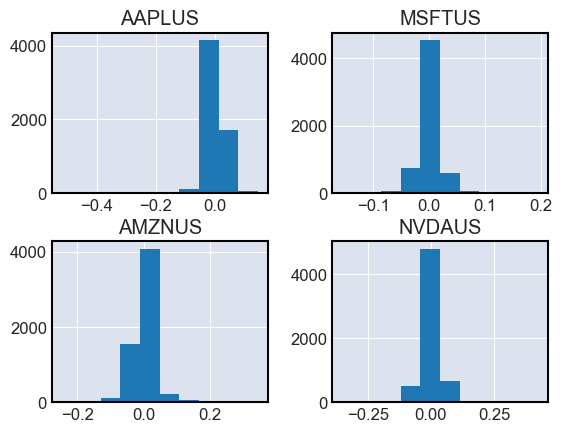

In [32]:
stocks_dailyReturns.hist()
plt.show()

In [33]:
stocks_totalReturns["sharpeRatio"]=stocks_sharpeRatio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio
AAPLUS,439.528784,0.289594,0.135537,2.572865,-1.266637,31.168818,0.711874
MSFTUS,7.707018,0.094620,0.055165,1.961856,0.252764,9.284623,0.305033
AMZNUS,26.317073,0.148174,0.110391,3.358920,1.075665,13.130677,0.278998
NVDAUS,387.368607,0.282823,0.172024,3.833215,0.600957,11.425115,0.466640


abs(skew) > 1 - Highly skewed distribution
abs(skew) > 0.5 - Moderatly skewed distribution
abs(skew) <= 0.5 - Approximately symmetric distribution (MSFT)

kurtosis = 3 - mesocurtic (normal distribution)
kurtosis < 3 - piatycurtic (tails are shorter and thinner, central peak is lower and broader)
kurtosis > 3 - leptocurtic (tails are longer and fatter, central peak is higher and sharper (fat tailed))

In [34]:
sortino_ratio = pd.Series(index=stocks.columns, dtype='float64')
for item in stocks.columns:
    downside_returns = stocks_dailyReturns[item].loc[stocks_dailyReturns[item] < target_return]
    expected_return = stocks_dailyReturns[item].mean()
    down_stdev = downside_returns.std()
    sortino_temp = (expected_return - rfr)/down_stdev
    sortino_ratio.update(pd.Series([sortino_temp], index=[item]))

In [35]:
stocks_totalReturns["sortinoRatio"]=sortino_ratio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio,sortinoRatio
AAPLUS,439.528784,0.289594,0.135537,2.572865,-1.266637,31.168818,0.711874,0.068863
MSFTUS,7.707018,0.094620,0.055165,1.961856,0.252764,9.284623,0.305033,0.038833
AMZNUS,26.317073,0.148174,0.110391,3.358920,1.075665,13.130677,0.278998,0.047302
NVDAUS,387.368607,0.282823,0.172024,3.833215,0.600957,11.425115,0.466640,0.065473


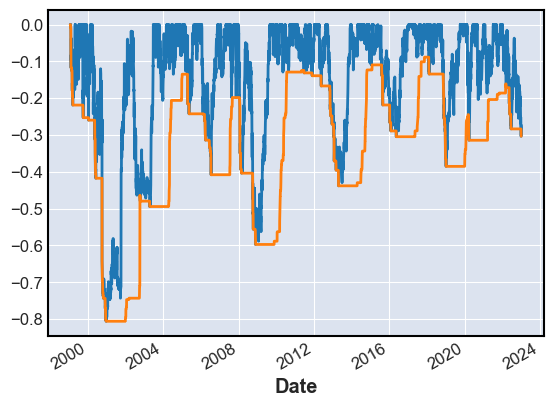

In [36]:
# Calculate the maximum value of returns using rolling().max()
roll_max = stocks['AAPLUS'].rolling(center=False, min_periods=1, window=250).max()
# Calculate daily draw-down from rolling max
daily_drawdown = stocks['AAPLUS']/roll_max - 1.0
# Calculate maximum daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=250).min()
# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show()

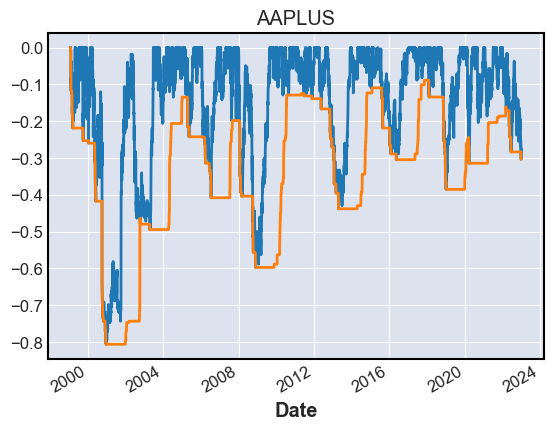

Biggest fall in analyzed period : - -0.8058


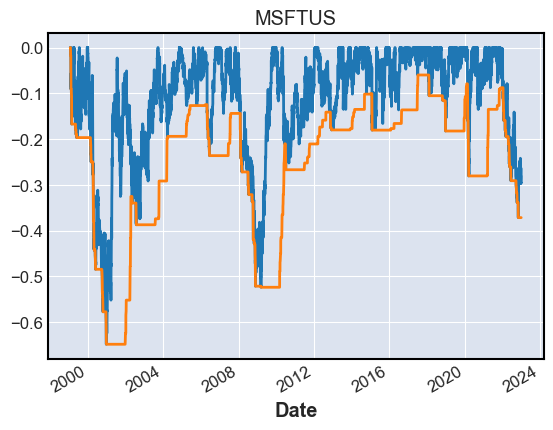

Biggest fall in analyzed period : - -0.648


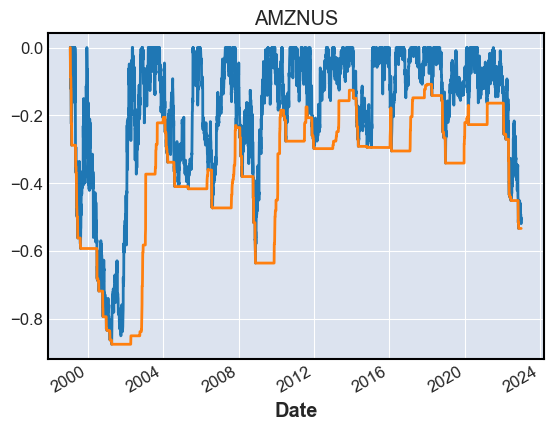

Biggest fall in analyzed period : - -0.8757


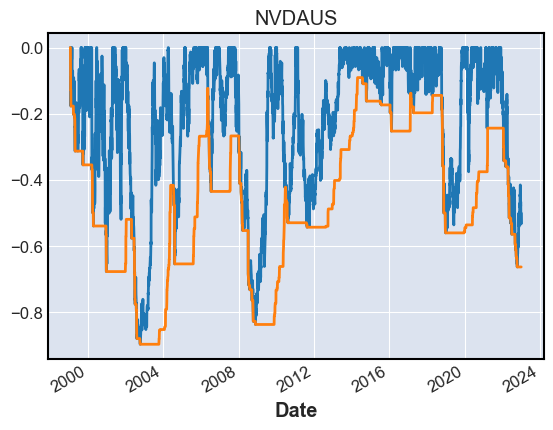

Biggest fall in analyzed period : - -0.8971


In [37]:
for stock in stocks:
    lookback_period = 250
    # Calculate the maximum value of returns using rolling().max()
    roll_max = stocks[stock].rolling(center = False, min_periods = 1, window = lookback_period).max()
    # Calculate daily draw-down from rolling max
    daily_drawdown = stocks[stock]/roll_max - 1.0
    # Calculate maximum daily draw-down
    max_daily_drawdown = daily_drawdown.rolling(center = False, min_periods = 1, window = lookback_period).min()
    daily_drawdown.plot()
    max_daily_drawdown.plot()
    plt.title(stock)
    plt.show()
    print('Biggest fall in analyzed period : -',round(min(max_daily_drawdown),4))


In [38]:
max_daily_drawdown.min()

-0.8970681502796363

In [39]:
daily_drawdown

Date
1999-01-22    0.000000
1999-01-25    0.000000
1999-01-26   -0.077406
1999-01-27   -0.077406
1999-01-28   -0.082915
                ...   
2022-12-23   -0.494700
2022-12-27   -0.530755
2022-12-28   -0.533579
2022-12-29   -0.514738
2022-12-30   -0.500591
Name: NVDAUS, Length: 6021, dtype: float64

In [40]:
# We want to calculate recovery time as well
# Our daily draw-down should be also time dependent i.e. from previous ATH

A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value". Let's see how our S&P500 returns relate to the returns of these factors. 

In [41]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(stocks)

In [42]:
# Calculate the covariance matrix S
Sigma = risk_models.sample_cov(stocks)

In [43]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, Sigma)
print (mu, Sigma)

AAPLUS    0.290262
MSFTUS    0.094822
AMZNUS    0.148497
NVDAUS    0.283474
dtype: float64           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166815  0.059951  0.079059  0.101353
MSFTUS  0.059951  0.096992  0.070595  0.087140
AMZNUS  0.079059  0.070595  0.284315  0.106651
NVDAUS  0.101353  0.087140  0.106651  0.370277


In [44]:
# Get the minimum risk portfolio for a target return 
weights = ef.efficient_return(0.25)
print (weights)

# Show portfolio performance 
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.6583799643622262), ('MSFTUS', 0.1755517449289636), ('AMZNUS', 0.0357464736585957), ('NVDAUS', 0.1303218170502144)])
Expected annual return: 25.0%
Annual volatility: 35.0%
Sharpe Ratio: 0.66


(0.25, 0.3504113768584535, 0.6563713828643956)

In [45]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_ms = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe = ef_ms.max_sharpe()
cleaned_weights_maxsharpe = ef_ms.clean_weights()
print (raw_weights_maxsharpe, cleaned_weights_maxsharpe)
perf_max_sharpe=ef_ms.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.8158574654801204), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.1841425345198796)]) OrderedDict([('AAPLUS', 0.81586), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.18414)])
Expected annual return: 28.9%
Annual volatility: 39.2%
Sharpe Ratio: 0.69


In [46]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_mv = EfficientFrontier(mu, Sigma)
raw_weights_minvolatility = ef_mv.min_volatility()
cleaned_weights_minvolatility = ef_mv.clean_weights()
print (raw_weights_minvolatility, cleaned_weights_minvolatility)
perf_min_volatility=ef_mv.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.2368276535587821), ('MSFTUS', 0.6981196222435331), ('AMZNUS', 0.0650527241976849), ('NVDAUS', 0.0)]) OrderedDict([('AAPLUS', 0.23683), ('MSFTUS', 0.69812), ('AMZNUS', 0.06505), ('NVDAUS', 0.0)])
Expected annual return: 14.5%
Annual volatility: 29.4%
Sharpe Ratio: 0.42


In [47]:
print(cleaned_weights_minvolatility,cleaned_weights_maxsharpe,perf_min_volatility,perf_max_sharpe, sep="\n")

OrderedDict([('AAPLUS', 0.23683), ('MSFTUS', 0.69812), ('AMZNUS', 0.06505), ('NVDAUS', 0.0)])
OrderedDict([('AAPLUS', 0.81586), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.18414)])
(0.14459909749559433, 0.2941126088519707, 0.4236441884690026)
(0.2890121893854051, 0.3924851860473534, 0.6854072432505739)


In [48]:
Sigma

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.166815,0.059951,0.079059,0.101353
MSFTUS,0.059951,0.096992,0.070595,0.087140
AMZNUS,0.079059,0.070595,0.284315,0.106651
NVDAUS,0.101353,0.087140,0.106651,0.370277


In [50]:
# Exponential weights for matrix
# Define exponentially weightedSigma and mu using stock_prices
Sigma = risk_models.exp_cov(stocks, span=180, frequency=252)
mu = expected_returns.ema_historical_return(stocks, frequency=252, span=180)

# Calculate the efficient frontier
ef_exp_ms = EfficientFrontier(mu, Sigma)

# Calculate weights for the maximum sharpe ratio optimization 
# raw_exp_weights_maxsharpe = ef_exp_ms.max_sharpe() /UNCOMMENT LATER
# ValueError: at least one of the assets must have an expected return exceeding the risk-free rate
# cleaned_exp_weights_maxsharpe = ef_exp_ms.clean_weights() /UNCOMMENT LATER

# Show portfolio performance 
# ef_exp_ms.portfolio_performance(verbose=True) /UNCOMMENT LATER


Great work! Interesting isn't it, that by playing around with the span, you get two completely different type of portfolios, each with a very different Sharpe ratio. If your data is very volatile and changes rapidly, working with a short span might give you better predictive power of the expected return, with a faster moving investment strategy. However, if your data is rather slow moving as is the case with this data, the short span does not help you in better predicting expected risk and returns. Let's now recap what we've learned in this course

FACTOR MODELS - FOR EXAMPLE FAMA FRENCH MODEL 
Frequency resampling primer

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

The DataFrame and Series Pandas objects have a built-in .resample() method that specifies the lower frequency. This method is chained with a method to create the lower-frequency statistic, such as .mean() for the average of the data within the new frequency period, or .min() for the minimum of the data.

In this exercise you'll practice converting daily returns data to weekly and quarterly frequency.

You've got the hang of it! Resampling is an oft-overlooked but extremely important tool for time series and risk factor analysis, and we'll use it in the following exercise.

Add a constant to the regression
mort_del = sm.add_constant(mort_del)

Create the regression factor model and fit it to the data
results = sm.OLS(port_q_mean, mort_del).fit()

Print a summary of the results
print(results.summary())

### Efficient frontier for exponential weights

In [51]:
# Exponential weights for matrix
# Compute the sample covariance matrix of returns
sample_cov = stocks.pct_change().cov() * 252
# Create the CovarianceShrinkage instance variable
cs = risk_models.CovarianceShrinkage(stocks)

# TBU 2022-12-12
#### Expected returns - same name as earlier
mu = expected_returns.mean_historical_return(stocks)
# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

efficient_portfolio = CLA(mu, e_cov)
print(efficient_portfolio.min_volatility())

Sample Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166815  0.059951  0.079059  0.101353
MSFTUS  0.059951  0.096992  0.070595  0.087140
AMZNUS  0.079059  0.070595  0.284315  0.106651
NVDAUS  0.101353  0.087140  0.106651  0.370277 

Efficient Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.167234  0.059515  0.078483  0.100615
MSFTUS  0.059515  0.097919  0.070081  0.086506
AMZNUS  0.078483  0.070081  0.283879  0.105875
NVDAUS  0.100615  0.086506  0.105875  0.369215 

OrderedDict([('AAPLUS', 0.24086216600583865), ('MSFTUS', 0.6905889098653762), ('AMZNUS', 0.06854892412878504), ('NVDAUS', 0.0)])


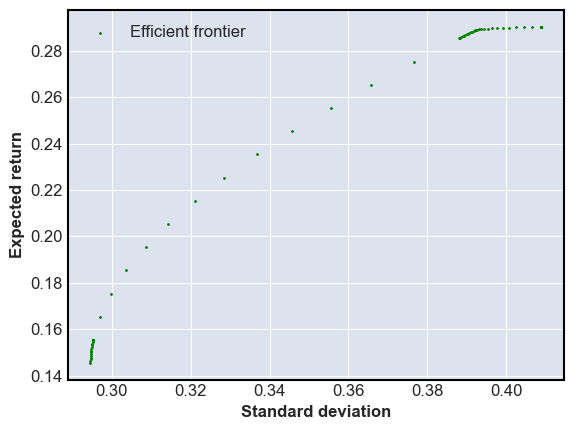

In [52]:
# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Efficient frontier')
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.legend()
plt.show()

### Efficient frontier in division per epochs

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_22656\3109471323.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


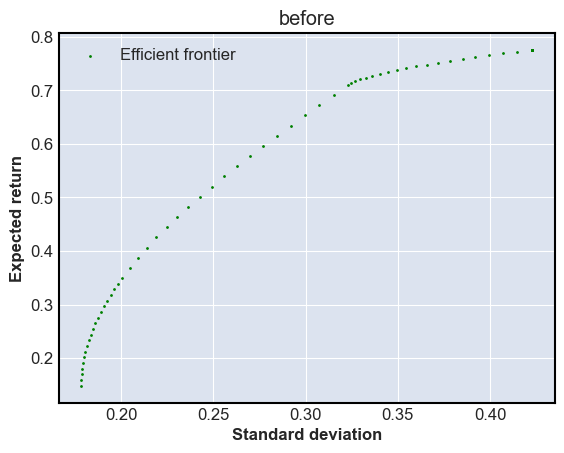

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_22656\3109471323.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


OrderedDict([('AAPLUS', 0.10920059029892806), ('MSFTUS', 0.7185241287297404), ('AMZNUS', 0.11532208016649173), ('NVDAUS', 0.05695320080483972)])


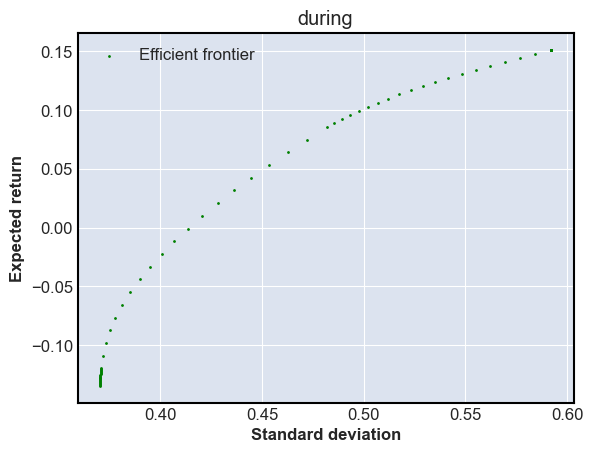

OrderedDict([('AAPLUS', 0.22422283692667058), ('MSFTUS', 0.7052240619326882), ('AMZNUS', 0.05173600914676272), ('NVDAUS', 0.01881709199387873)])


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_22656\3109471323.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


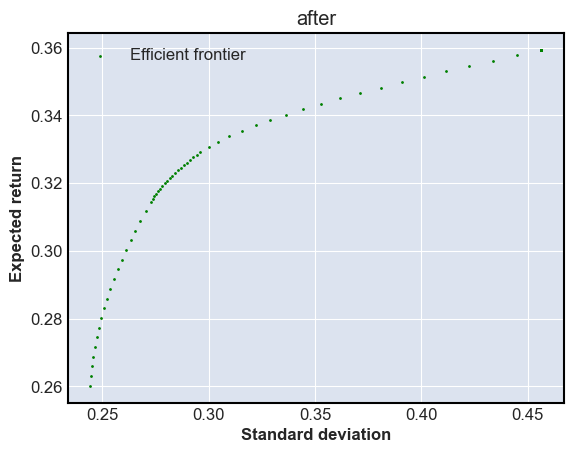

OrderedDict([('AAPLUS', 0.3624734488262385), ('MSFTUS', 0.49944774162978645), ('AMZNUS', 0.1380788095439751), ('NVDAUS', 0.0)])


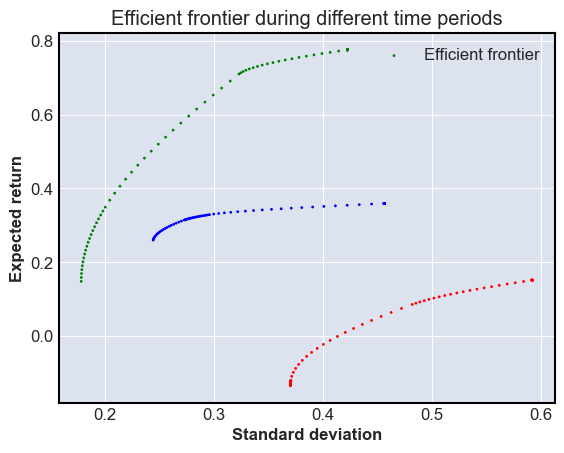

In [53]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1/1/2005', 'end': '31/12/2006'},
           'during' : {'start': '1/1/2007', 'end': '31/12/2008'},
           'after'  : {'start': '1/1/2009', 'end': '31/12/2022'}
         }

# Compute the efficient covariance for each epoch
mu_epoch = {}
e_cov_epoch = {}
efficient_portfolio_epoch = {}
Epoch_frontier = pd.DataFrame(columns =['returns','volume','epoch'])

for xi in epochs.keys():
    sub_price = stocks.loc[epochs[xi]['start']:epochs[xi]['end']]
    mu_epoch[xi] = expected_returns.mean_historical_return(sub_price)
    e_cov_epoch[xi] = risk_models.CovarianceShrinkage(sub_price).ledoit_wolf()
    efficient_portfolio_epoch[xi] = CLA(mu_epoch[xi], e_cov_epoch[xi])
    (ret, vol, weights) = efficient_portfolio_epoch[xi].efficient_frontier()
    frontier_new_data = pd.concat([pd.Series(ret), pd.Series(vol)], axis=1, keys=('returns','volume'))
    frontier_new_data["epoch"]=xi
    Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )
    
    plt.scatter(vol, ret, s = 4, c = 'g', marker = '.')
    plt.title(xi)
    plt.legend(['Efficient frontier'])
    plt.xlabel('Standard deviation', fontsize=12)
    plt.ylabel('Expected return', fontsize=12)
    plt.show()
    print(efficient_portfolio_epoch[xi].min_volatility())   

# Display the efficient covariance matrices for all epochs

colors = {'before':'green', 'during':'red', 'after':'blue'}


plt.scatter(Epoch_frontier["volume"], Epoch_frontier["returns"], s = 4, c = Epoch_frontier['epoch'].map(colors), marker = '.')
plt.title('Efficient frontier during different time periods')
plt.legend(['Efficient frontier'])
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.show()

In [54]:
print("Efficient Covariance Matrices\n", e_cov_epoch)

Efficient Covariance Matrices
 {'before':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.147889  0.013446  0.030137  0.044699
MSFTUS  0.013446  0.038666  0.013966  0.017037
AMZNUS  0.030137  0.013966  0.141058  0.039313
NVDAUS  0.044699  0.017037  0.039313  0.178670, 'during':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.245150  0.100863  0.158341  0.155547
MSFTUS  0.100863  0.150890  0.114211  0.121264
AMZNUS  0.158341  0.114211  0.350651  0.160970
NVDAUS  0.155547  0.121264  0.160970  0.451432, 'after':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.084765  0.044925  0.047733  0.067565
MSFTUS  0.044925  0.072773  0.051587  0.068053
AMZNUS  0.047733  0.051587  0.120845  0.071435
NVDAUS  0.067565  0.068053  0.071435  0.208327}


In [55]:
print("Efficient Covariance Matrices\n", mu_epoch)

Efficient Covariance Matrices
 {'before': AAPLUS    0.640689
MSFTUS    0.056978
AMZNUS   -0.058768
NVDAUS    0.775673
dtype: float64, 'during': AAPLUS    0.009354
MSFTUS   -0.193543
AMZNUS    0.151437
NVDAUS   -0.421331
dtype: float64, 'after': AAPLUS    0.317109
MSFTUS    0.213808
AMZNUS    0.278150
NVDAUS    0.359367
dtype: float64}


### Value-at-Risk (VaR)

In [56]:
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2022-12-23,151.975000
2022-12-27,147.810000
2022-12-28,145.687500


In [57]:
portfolio_return

0.0011827914261047195

1.6448536269514722
95% VaR:  1.6448536269514722 ; 99% VaR:  2.319458506183113


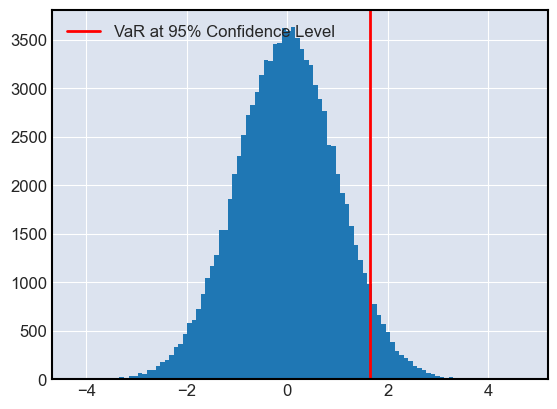

In [58]:
# assuming normal distribution

VaR_95 = stats.norm.ppf(0.95)
print(VaR_95)
draws = stats.norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend()
plt.show()

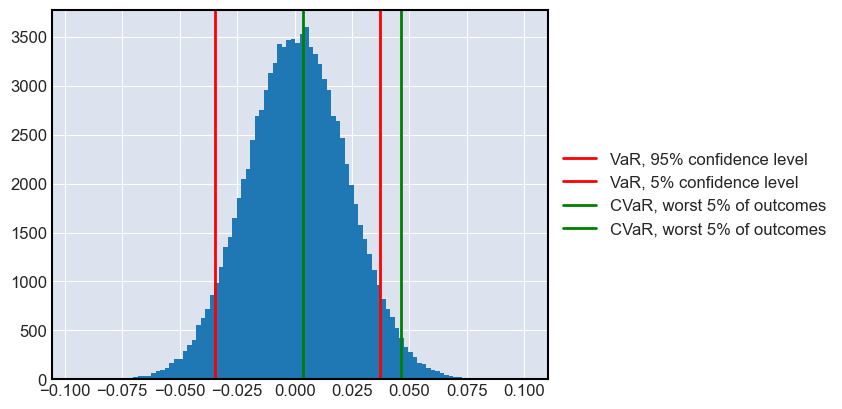

In [59]:
# Compute the mean and standard deviation of the portfolio returns
pm = portfolio_dailyReturns.mean()[0]
ps = portfolio_dailyReturns.std()[0]

# Compute the 95% VaR using the .ppf()
VaR_95 = stats.norm.ppf(0.95, loc = pm, scale = ps)
VaR_05 = stats.norm.ppf(0.05, loc = pm, scale = ps) # To be confirmed if I can use that
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = stats.norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
tail_loss_b = stats.norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_05) # To be confirmed if I can use that
# ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all()
CVaR_95 = (1 / (1 - 0.95)) * tail_loss
CVaR_05 = (1 / (1 - 0.05)) * tail_loss_b

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(stats.norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = VaR_05, c='r', label = "VaR, 5% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.axvline(x = CVaR_05, c='g', label = "CVaR, worst 5% of outcomes") # To be confirmed if I can use that
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

it's generally the case that CVaR is the preferred risk measure for risk management. One reason is that it is affected by the tail of the loss distribution, while VaR is a static value. 

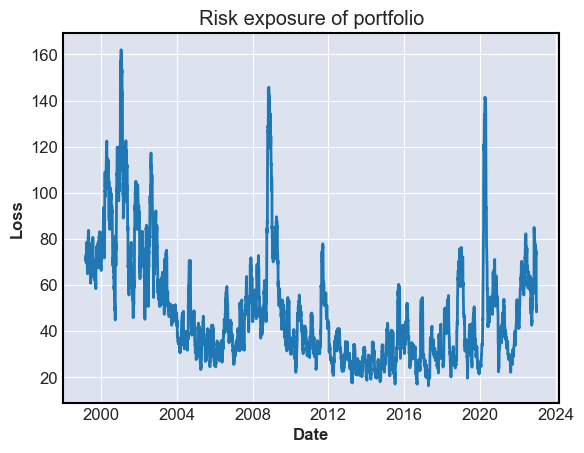

In [62]:
# Create rolling window parameter list
mu = portfolio_dailyReturns.rolling(30).mean()
# Need to convert DataFrame to Series for the enumerator to work correctly
mu = mu.squeeze()
sigma = portfolio_dailyReturns.rolling(30).std()
sigma = sigma.squeeze()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ stats.t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(portfolio_dailyReturns.index, 0.01 * VaR_99 * 100000)
plt.title('Risk exposure of portfolio')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

In [63]:
# Fit the Student's t distribution to crisis losses
p = stats.t.fit(portfolio_dailyReturns[1:]) #Excluding first observation because of 'NaN' value

# Compute the VaR_99 for the fitted distribution
VaR_99 = stats.t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = stats.t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

0.09921907433955855


Recall that CVaR is the expected value of loss given a minimum loss threshold. So CVaR is already in the form of a risk exposure--it is the sum (or integral) of the probability of loss in the distribution tail multiplied, by the loss amount.

Great! The Student's t-distribution is widely used when the Normal distribution is too restrictive for portfolio losses, but still allows convergence to the Normal when the sample size becomes very large.

In [66]:
fitted

(3.023207828494012, 0.0014051807681790748, 0.014101333919769322)

In [71]:
portfolio_dailyReturns[1:]

,Portfolio
Date,
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
1999-01-29,-0.021014
...,...
2022-12-23,0.002056
2022-12-27,-0.029642
2022-12-28,-0.015413


In [72]:
fitted_in = portfolio_dailyReturns[1:].to_numpy()

In [74]:
fitted_in

array([[ 0.01750098],
       [ 0.00835549],
       [ 0.01641302],
       ...,
       [-0.01541281],
       [ 0.0312985 ],
       [-0.0009634 ]])

In [77]:
portfolio_dailyReturns[1:].isna().sum()

Portfolio    0
dtype: int64

In [78]:
np.isinf(portfolio_dailyReturns[1:]).sum().all()

False

In [80]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(portfolio_dailyReturns[1:])
print(type(kde))

# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

<class 'sklearn.neighbors._kde.KernelDensity'>


In [83]:
fitted = stats.gaussian_kde.evaluate(points = portfolio_dailyReturns[1:])

# https://medium.com/analytics-vidhya/kernel-density-estimation-kernel-construction-and-bandwidth-optimization-using-maximum-b1dfce127073
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

# Kernel density - funkcja gęstości
# https://pl.wikipedia.org/wiki/Funkcja_g%C4%99sto%C5%9Bci_prawdopodobie%C5%84stwa
# https://www.szkolnictwo.pl/szukaj,Funkcja_g%C4%99sto%C5%9Bci_prawdopodobie%C5%84stwa

# 2023/01/02 - jak wygenerować funkcję gestości prawdopodobieństwa z 1 wymiarowego ds?

# https://ekamperi.github.io/math/2020/12/08/kernel-density-estimation.html


TypeError: evaluate() missing 1 required positional argument: 'self'

In [ ]:
from scipy.stats import gaussian_kde


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

# https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
fitted = kde_scipy(portfolio_dailyReturns[1:])

In [73]:
# VaR from a fitted distribution
# Visualize the fitted distribution with a plot

# Fit the Student's t distribution to crisis losses
fitted = stats.gaussian_kde(fitted_in)


# In this exercise a fitted loss distribution is provided, 
# which fits losses from an equal-weighted investment bank portfolio from 2005-2010.
x = np.linspace(-0.25,0.25,1000)
plt.plot(x,fitted.evaluate(x))
plt.show()

# Create a random sample of 100,000 observations from the fitted distribution
sample = fitted.resample(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, .95)
print(VaR_95)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\kde.py:563: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs